NYC Taxi Trip Duration (Ensemble Learning)
Now, that we have seen the Exploration and have a good understanding of data shape and structure.

We also looked at firstly the basic models such as decision tree and linear regression.
We created some features using the existing features in the dataset and also some features using external data
In this Notebook, we will cover the different ensemble methods and check if we can do better given the same set of features that we had created. Ensemble Techniques covered:

Random Forest
XGBoost (Gradient Boosting)
Averaging Predictions
Stacking
Finally, we will compare the results of these models and conclude with some other ideas for additional features that can be integrated to improve performance.
Data Dictionary
It is always a good idea to have the data dictionary handy.

id - a unique identifier for each trip
vendor_id - a code indicating the provider associated with the trip record
pickup_datetime - date and time when the meter was engaged
dropoff_datetime - date and time when the meter was disengaged
passenger_count - the number of passengers in the vehicle (driver entered value)
pickup_longitude - the longitude where the meter was engaged
pickup_latitude - the latitude where the meter was engaged
dropoff_longitude - the longitude where the meter was disengaged
dropoff_latitude - the latitude where the meter was disengaged
store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
trip_duration - duration of the trip in seconds
Here dropoff_datetime and trip_duration are only available for the df set as that represents the target

# Load Libraries
We will load libraries required to build models and validation sets

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load Data & Preprocessing

In [2]:
df = pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\nyc_taxi_trip_duration.csv')

In [3]:
#converting string to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [4]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

# Feature Engineering
Eucledian Distance

In [5]:
#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5


Haversine Distance

In [6]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)

Fastest route

In [7]:
fr1 = pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\fastest_routes_train_part_1.csv',usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\fastest_routes_train_part_2.csv',usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


# Binning

In [8]:
### Binned Coordinates ###
df['pickup_latihttp://localhost:8888/notebooks/Untitled58.ipynb#tude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

One Hot Encoding

In [9]:
df.vendor_id.value_counts()

2    390481
1    338841
Name: vendor_id, dtype: int64

In [10]:
df['vendor_id'] = df['vendor_id'] - 1

In [11]:
# For a route, the total distance and travel time are not available. Let's impute that with 0
df.fillna(0, inplace = True)

In [12]:
df = df.drop(['id', 'pickup_datetime','dropoff_datetime','trip_duration','store_and_fwd_flag'], axis=1)

# Model Building

In [13]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,...,dist_sq,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time,pickup_latihttp://localhost:8888/notebooks/Untitled58.ipynb#tude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.953918,40.778873,-73.963875,40.771164,0,9,16,40,...,0.000159,0.012592,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,0,2,-73.988312,40.731743,-73.994751,40.694931,4,10,23,35,...,0.001397,0.037371,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,1,2,-73.997314,40.721458,-73.948029,40.774918,6,7,17,59,...,0.005287,0.072712,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,1,6,-73.961670,40.759720,-73.956779,40.780628,1,1,9,44,...,0.000461,0.021473,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,0,1,-74.017120,40.708469,-73.988182,40.740631,2,7,6,42,...,0.001872,0.043264,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988


# Cross validation
We will again use a similar function for cross validation as previously done to check performance of various ensemble models.

In [14]:
from math import sqrt
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index].values,df1.loc[test_index].values
        ytr,yvl = df_y[train_index].values,df_y[test_index].values

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

# Ensemble Models
Now that we have seen the performance of individual models, we have noted that decision tree has far better performance than other algorithms and it would be a good idea to try decision tree based ensemble models to check whether we improve on existing decision tree model or not.

# Random Forest
Random forests are an ensemble learning method for classification and regression that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Considering that we got a much more improved performance with decision trees. It is worthwhile to check tree based ensemble techniques.

In [16]:
rf_params = {'random_state': 0, 'n_estimators': 10, 'max_depth': 8, 'n_jobs': -1, "min_samples_split": 43}
rf_scores = cv_score(RandomForestRegressor(**rf_params))


1 of kfold 5
Valid RMSE: 0.43667

2 of kfold 5
Valid RMSE: 0.43771

3 of kfold 5
Valid RMSE: 0.42844

4 of kfold 5
Valid RMSE: 0.43319

5 of kfold 5
Valid RMSE: 0.43020


# XGBoost¶
Looking at the performance of Random forest, it would be a good idea to try XGBoost which is based on gradient boosting techniques and check performance.

First we will set the hyperparameters for XGBoost and use cross validation to track and figure out the correct number of rounds so that it does not overfit.

Later, we will fit the XGBoost Regressor using the number of rounds identified from the above step and check the cross validation scores

To find the approximate number of rounds for XGBoost, we will first create a validation set and check performance after each round.

In [17]:
#Splitting the data into df and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

In [18]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dvalid = xgb.DMatrix(xtest, label=ytest)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Finally! We're ready to use XGBoost. You'll notice that this part is actually quite short. But only in code. It can take quite a while to iterate through the different parameters and different values of these parameters to better the outcome of the model. There are several ways to do this and we will cover this in a later module.

In [19]:
xgb_params = {}
xgb_params["objective"] = "reg:linear"
xgb_params['eval_metric'] = "rmse"
xgb_params["eta"] = 0.05
xgb_params["min_child_weight"] = 10
xgb_params["subsample"] = 0.9
xgb_params["colsample_bytree"] = 0.7
xgb_params["max_depth"] = 5
xgb_params['silent'] = 1
xgb_params["seed"] = 2019
xgb_params["nthread"] = -1
xgb_params["lambda"] = 2

xgb_model = xgb.train(xgb_params, dtrain, 2000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=200)
print('Modeling RMSE %.5f' % xgb_model.best_score)

[14:01:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:5.72173	valid-rmse:5.71901
[200]	train-rmse:0.39291	valid-rmse:0.40221
[400]	train-rmse:0.38072	valid-rmse:0.39444
[600]	train-rmse:0.37356	valid-rmse:0.39126
[800]	train-rmse:0.36838	valid-rmse:0.38970
[1000]	train-rmse:0.36431	valid-rmse:0.38864
[1200]	train-rmse:0.36060	valid-rmse:0.38781
[1400]	train-rmse:0.35723	valid-rmse:0.38713
[1600]	train-rmse:0.35425	valid-rmse:0.38655
[1800]	tra

Again, you can try tweaking parameters here but Be very careful, as boosting models have a high chance of overfitting i.e. training your model so well on the training set that it performs quite poorly on unseen data. Here I would suggest playing with colsample_bytree and subsample to control overfitting.

Now, we can investigate the importance of each feature, to understand what affects the trip duration the most significantly. Here's how XGBoost allows us to do it:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

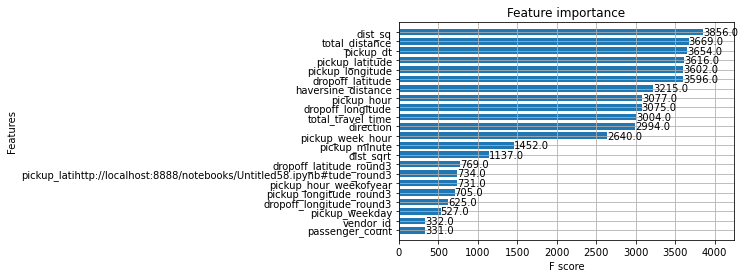

In [20]:
xgb.plot_importance(xgb_model, max_num_features=28, height=0.7)

So from top to bottom we see which features have the greatest effect on trip duration. It makes logical sense that the lattitude and longitude have high impact on predicting the trip duration. The further you travel, the longer it'll take. Interestingly, day of month is ranked higher here than day of week.

Remember that this is one way of looking at importance of features and it only signifies how important is a variable for XGBoost while fitting the training set.

In [21]:
xgb_params['num_round'] = xgb_model.best_iteration
xgb_model_final = xgb.XGBRegressor()
xgb_scores = cv_score(xgb_model_final)


1 of kfold 5
Valid RMSE: 0.39082

2 of kfold 5
Valid RMSE: 0.39243

3 of kfold 5
Valid RMSE: 0.38208

4 of kfold 5
Valid RMSE: 0.38715

5 of kfold 5
Valid RMSE: 0.38334


# Averaging
Bagging and boosting are 2 techniques. Now, we will cover 2 more advanced techniques.

First ensemble is an averaging model. Here, we simply take a weighted average of multiple models. The general rule here is to assign higher weight to the model which is giving better performance on the validation set.

I have defined a fresh function here to fit and calculate the scores from an averaged model comprising of XGBoost and Random Forest.

In [22]:
def cv_score_avg(ml_model_1, ml_model_2,w1 = 0.5, w2 = 0.5, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model_1
        ml_model_1.fit(xtr, ytr)
        pred_val_1 = ml_model_1.predict(xvl)
        
        model = ml_model_2
        ml_model_2.fit(xtr, ytr)
        pred_val_2 = ml_model_2.predict(xvl)
        
        final_pred=(pred_val_1*w1 + pred_val_2*w2)

        rmse_score = sqrt(mean_squared_error(yvl, final_pred))
        
        sufix = ""
        msg = ""
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

In [23]:
avg_scores = cv_score_avg(xgb_model_final, RandomForestRegressor(**rf_params), w1 = 0.4, w2 = 0.6)


1 of kfold 5
Valid RMSE: 0.40786

2 of kfold 5
Valid RMSE: 0.40909

3 of kfold 5
Valid RMSE: 0.39914

4 of kfold 5
Valid RMSE: 0.40466

5 of kfold 5
Valid RMSE: 0.40079


# Stacking
Second ensemble is a stacked model. Mlxtend library includes code for this that does the out-of-fold predictions and later fitting the second-level model. Let's see how this works now.

In [24]:
# Model Definitions for feeding into Stacking
xgb_model = xgb.XGBRegressor(**xgb_params)
rf_model = RandomForestRegressor(**rf_params)
tree_model = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)

In [25]:
# Importing Stacking regressor from mlxtend
from mlxtend.regressor import StackingCVRegressor

stacked_model = StackingCVRegressor(
    regressors=[xgb_model, rf_model],
    meta_regressor=Ridge()
)

In [26]:
stacking_scores = cv_score(stacked_model)


1 of kfold 5
[15:06:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:07:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some par

<AxesSubplot:>

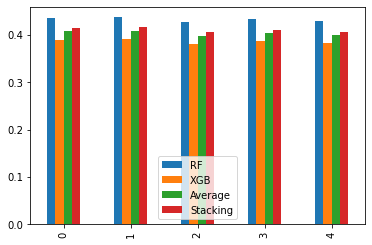

In [27]:
results_df = pd.DataFrame({'RF':rf_scores, 'XGB': xgb_scores, 'Average': avg_scores, 'Stacking':stacking_scores})
results_df.plot(y=["RF", "XGB","Average","Stacking"], kind="bar")

Stacking does give us the best performance out of all ensemble techniques as is clear from the plot above. However, averaging did not perform much better and this is due to the difference in performance of RF and XGBoost. Tweaking some hyperparameters to make RF better and ultimately create new weighted ensemble can give better perfomance. This is left as an exercise for the students.

# featre engineering
add new column weather to dataset

In [31]:
df = pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\nyc_taxi_trip_duration.csv')

In [32]:
#converting string to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [33]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

In [34]:
#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5

In [35]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)

In [36]:
fr1 = pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\fastest_routes_train_part_1.csv',usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\fastest_routes_train_part_2.csv',usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [37]:
### Binned Coordinates ###
df['pickup_latihttp://localhost:8888/notebooks/Untitled58.ipynb#tude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

In [38]:
df['vendor_id'] = df['vendor_id'] - 1


## add a new feature weather from lattitude value three types of weather conditions which are very cold,hot,very hot according to the lattitude values - ordinal encoding
#label encoding
#-90 to -45 - very cold (1)
#-45 to -30 - hot (2)
#-30-0 very hot (3)
#0-30 very hot (3)
#30-45 hot (2)
#45-90 very cold (1)



In [39]:
def weather(x):
    if x>=-90 and x<=-45:
        return 1
    elif x>-45 and x<-30:
        return 2
    elif x>-30 and x<=0:
        return 3
    elif x>0 and x<=30:
        return 3
    elif x>30 and x<=45:
        return 2
    
    else:
        return 1
 
# Applying the wether conditions
df['pickup_weather'] = df['pickup_latitude'].apply(weather)
df['dropoff_weather']=df['dropoff_latitude'].apply(weather)

In [40]:
df.isnull().sum()
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,total_distance,total_travel_time,pickup_latihttp://localhost:8888/notebooks/Untitled58.ipynb#tude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,pickup_weather,dropoff_weather
0,id1080784,1,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964,2,2
1,id0889885,0,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995,2,2
2,id0857912,1,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948,2,2
3,id3744273,1,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957,2,2
4,id0232939,0,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988,2,2


# Add new feature season from the pickup date and month - Label encoding

#Dec-Feb - Winter (1)
#MArch - MAy - Summer (2)
#June - Sep -Monsoon (3)
#Oct - Nov - Autumn (4)

In [41]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_weekday', 'pickup_hour_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour',
       'dist_sq', 'dist_sqrt', 'haversine_distance', 'direction',
       'total_distance', 'total_travel_time',
       'pickup_latihttp://localhost:8888/notebooks/Untitled58.ipynb#tude_round3',
       'pickup_longitude_round3', 'dropoff_latitude_round3',
       'dropoff_longitude_round3', 'pickup_weather', 'dropoff_weather'],
      dtype='object')

In [42]:

df["pickup_datetime"].dt.week.head()
def season(x):
    #print(x)
    if x in [6,7,8,9,1,2,3,4,5,49,50,51,52,53]:
        return 1
    elif x in [10,11,12,13,14,15,16,17,18,19,20,21,22]:
        return 2
    elif x in [23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]:
        return 3
    elif x in [41,42,43,44,45,46,47,48]:
        return 4
    
 
# Applying the wether conditions
df['pickup_season'] = df["pickup_datetime"].dt.week.apply(season)
df['dropoff_season']= df["dropoff_datetime"].dt.week.apply(season)

In [43]:
df.pickup_season.head(100)

0     1
1     2
2     1
3     1
4     1
     ..
95    2
96    1
97    2
98    3
99    1
Name: pickup_season, Length: 100, dtype: int64

# add new feature holidays - Label encoding
#holidays # 
#March-may - high (3)
#Dec-Feb= medium (2)
#June-sep - low (1)
#oct-nov - very low (0)

In [ ]:

df["pickup_datetime"].dt.week.head()
def holidays(x):
    if x in [6,7,8,9,1,2,3,4,5,49,50,51,52,53]:
        return 2
    elif x in [10,11,12,13,14,15,16,17,18,19,20,21,22]:
        return 3
    elif x in [23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]:
        return 1
    elif x in [41,42,43,44,45,46,47,48]:
        return 0
   
 
# Applying the wether conditions
df['season_holidays'] = df["pickup_datetime"].dt.week.apply(holidays)


In [44]:
df.head()
df.isnull().sum()


id                                                                         0
vendor_id                                                                  0
pickup_datetime                                                            0
dropoff_datetime                                                           0
passenger_count                                                            0
pickup_longitude                                                           0
pickup_latitude                                                            0
dropoff_longitude                                                          0
dropoff_latitude                                                           0
store_and_fwd_flag                                                         0
trip_duration                                                              0
pickup_weekday                                                             0
pickup_hour_weekofyear                                                     0

Fill the null values with 0 for the following two features 

In [54]:
df['total_distance']=df['total_distance'].fillna(0)
df['total_travel_time']=df['total_travel_time'].fillna(0)


In [55]:
df.isnull().sum()

vendor_id                                                                  0
passenger_count                                                            0
pickup_longitude                                                           0
pickup_latitude                                                            0
dropoff_longitude                                                          0
dropoff_latitude                                                           0
pickup_weekday                                                             0
pickup_hour_weekofyear                                                     0
pickup_hour                                                                0
pickup_minute                                                              0
pickup_dt                                                                  0
pickup_week_hour                                                           0
dist_sq                                                                    0

WE can delete following fields since they are not longer required as pickup date and drop off date  is converted into other forms and trip duration and recording feature has no impact on modeling

In [45]:
df = df.drop(['id', 'pickup_datetime','dropoff_datetime','trip_duration','store_and_fwd_flag'], axis=1)

In [56]:
df.dtypes

vendor_id                                                                    int64
passenger_count                                                              int64
pickup_longitude                                                           float64
pickup_latitude                                                            float64
dropoff_longitude                                                          float64
dropoff_latitude                                                           float64
pickup_weekday                                                               int64
pickup_hour_weekofyear                                                       int64
pickup_hour                                                                  int64
pickup_minute                                                                int64
pickup_dt                                                                  float64
pickup_week_hour                                                             int64
dist

All features are of numeric types so that we need not convert them into numberic

# model building

# Cross validation
We will again use a similar function for cross validation as previously done to check performance of various ensemble models.

In [57]:
from math import sqrt
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index].values,df1.loc[test_index].values
        ytr,yvl = df_y[train_index].values,df_y[test_index].values

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

# Ensemble Models
Now that we have seen the performance of individual models, we have noted that decision tree has far better performance than other algorithms and it would be a good idea to try decision tree based ensemble models to check whether we improve on existing decision tree model or not.

# Random Forest
Random forests are an ensemble learning method for classification and regression that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Considering that we got a much more improved performance with decision trees. It is worthwhile to check tree based ensemble techniques.

In [58]:
rf_params = {'random_state': 0, 'n_estimators': 19, 'max_depth': 11, 'n_jobs': -1, "min_samples_split": 43}
rf_scores = cv_score(RandomForestRegressor(**rf_params))


1 of kfold 5
Valid RMSE: 0.41877

2 of kfold 5
Valid RMSE: 0.42053

3 of kfold 5
Valid RMSE: 0.41124

4 of kfold 5
Valid RMSE: 0.41595

5 of kfold 5
Valid RMSE: 0.41307


XGBoost
Looking at the performance of Random forest, it would be a good idea to try XGBoost which is based on gradient boosting techniques and check performance.

First we will set the hyperparameters for XGBoost and use cross validation to track and figure out the correct number of rounds so that it does not overfit.

Later, we will fit the XGBoost Regressor using the number of rounds identified from the above step and check the cross validation scores

To find the approximate number of rounds for XGBoost, we will first create a validation set and check performance after each round.

In [61]:
#Splitting the data into df and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/4, random_state=0)

In [62]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dvalid = xgb.DMatrix(xtest, label=ytest)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Finally! We're ready to use XGBoost. You'll notice that this part is actually quite short. But only in code. It can take quite a while to iterate through the different parameters and different values of these parameters to better the outcome of the model. There are several ways to do this and we will cover this in a later module.

In [63]:
xgb_params = {}
xgb_params["objective"] = "reg:linear"
xgb_params['eval_metric'] = "rmse"
xgb_params["eta"] = 0.05
xgb_params["min_child_weight"] = 10
xgb_params["subsample"] = 0.9
xgb_params["colsample_bytree"] = 0.7
xgb_params["max_depth"] = 5
xgb_params['silent'] = 1
xgb_params["seed"] = 2019
xgb_params["nthread"] = -1
xgb_params["lambda"] = 2

xgb_model = xgb.train(xgb_params, dtrain, 2000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=200)
print('Modeling RMSE %.5f' % xgb_model.best_score)

[16:38:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:5.72151	valid-rmse:5.71855
[200]	train-rmse:0.39268	valid-rmse:0.40391
[400]	train-rmse:0.38166	valid-rmse:0.39703
[600]	train-rmse:0.37464	valid-rmse:0.39378
[800]	train-rmse:0.36939	valid-rmse:0.39189
[1000]	train-rmse:0.36524	valid-rmse:0.39075
[1200]	train-rmse:0.36175	valid-rmse:0.39006
[1400]	train-rmse:0.35855	valid-rmse:0.38935
[1600]	train-rmse:0.35558	valid-rmse:0.38871
[1800]	tra

# new features added does not create muh difference in rmse error rate but the training error and testing error performs much better way so we can assume that model will perform much better with training and testing data.
df.clumns


In [65]:
df.dtypes

vendor_id                                                                    int64
passenger_count                                                              int64
pickup_longitude                                                           float64
pickup_latitude                                                            float64
dropoff_longitude                                                          float64
dropoff_latitude                                                           float64
pickup_weekday                                                               int64
pickup_hour_weekofyear                                                       int64
pickup_hour                                                                  int64
pickup_minute                                                                int64
pickup_dt                                                                  float64
pickup_week_hour                                                             int64
dist

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

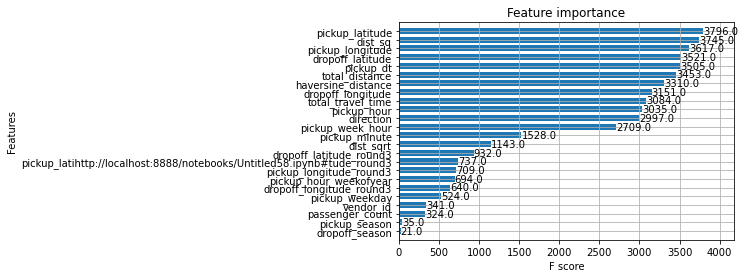

In [66]:
xgb.plot_importance(xgb_model, max_num_features=26, height=0.7)

So from top to bottom we see which features have the greatest effect on trip duration. It makes logical sense that the lattitude and longitude have high impact on predicting the trip duration. The further you travel, the longer it'll take. Interestingly, day of month is ranked higher here than day of week.

Remember that this is one way of looking at importance of features and it only signifies how important is a variable for XGBoost while fitting the training set.

In [67]:
xgb_params['num_round'] = xgb_model.best_iteration
xgb_model_final = xgb.XGBRegressor()
xgb_scores = cv_score(xgb_model_final)


1 of kfold 5
Valid RMSE: 0.39108

2 of kfold 5
Valid RMSE: 0.39288

3 of kfold 5
Valid RMSE: 0.38209

4 of kfold 5
Valid RMSE: 0.38684

5 of kfold 5
Valid RMSE: 0.38334


# After XGB RMSE value decreased considerably from .41 to .38 which means that model will perform much better way this is due to the addition of new featues ie these features  are important to the model 

# Averaging


Bagging and boosting are 2 techniques. Now, we will cover 2 more advanced techniques.

First ensemble is an averaging model. Here, we simply take a weighted average of multiple models. The general rule here is to assign higher weight to the model which is giving better performance on the validation set.

I have defined a fresh function here to fit and calculate the scores from an averaged model comprising of XGBoost and Random Forest.

In [68]:
def cv_score_avg(ml_model_1, ml_model_2,w1 = 0.5, w2 = 0.5, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model_1
        ml_model_1.fit(xtr, ytr)
        pred_val_1 = ml_model_1.predict(xvl)
        
        model = ml_model_2
        ml_model_2.fit(xtr, ytr)
        pred_val_2 = ml_model_2.predict(xvl)
        
        final_pred=(pred_val_1*w1 + pred_val_2*w2)

        rmse_score = sqrt(mean_squared_error(yvl, final_pred))
        
        sufix = ""
        msg = ""
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

In [69]:
avg_scores = cv_score_avg(xgb_model_final, RandomForestRegressor(**rf_params), w1 = 0.4, w2 = 0.6)


1 of kfold 5
Valid RMSE: 0.40012

2 of kfold 5
Valid RMSE: 0.40182

3 of kfold 5
Valid RMSE: 0.39169

4 of kfold 5
Valid RMSE: 0.39678

5 of kfold 5
Valid RMSE: 0.39356


# When averaging cv-scores the RMSE error is decreased from .4 to .39 this should be the impact of newly added features.

# Stacking

In [70]:
# Model Definitions for feeding into Stacking
xgb_model = xgb.XGBRegressor(**xgb_params)
rf_model = RandomForestRegressor(**rf_params)
tree_model = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)

In [71]:
# Importing Stacking regressor from mlxtend
from mlxtend.regressor import StackingCVRegressor

stacked_model = StackingCVRegressor(
    regressors=[xgb_model, rf_model],
    meta_regressor=Ridge()
)

In [72]:
stacking_scores = cv_score(stacked_model)


1 of kfold 5
[17:46:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:46:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some par

<AxesSubplot:>

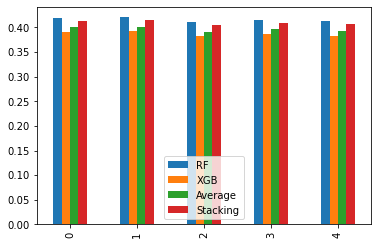

In [73]:
results_df = pd.DataFrame({'RF':rf_scores, 'XGB': xgb_scores, 'Average': avg_scores, 'Stacking':stacking_scores})
results_df.plot(y=["RF", "XGB","Average","Stacking"], kind="bar")

# When completed the ensemble model it is seen that XGB ensemble model is much better when ompared to other emsemble model algorithms. Here stacking and random forest gives worse results than the XGB boosting technique

# After adding new features to the dataset , all emsemble models performed in such a way that each time RMSE error for both training and evaluation decreased a bit. This is a clear indication that the model will perform in a better manner than earlier times in which the new features was not introduced with the dataset. This is a strong indiation that these features has a strong impact on creating the model and for prediction.This is creating a general assumption that when new features are created in different perspective for any dataset, the performance of the model will be improved.